In [5]:
import torch
import numpy as np

import os, sys
project_root_dir = os.path.join(os.getcwd(),'../..')
if project_root_dir not in sys.path:
    sys.path.append(project_root_dir)
    import config

# Classification Metrics

In [ ]:
save_dir = os.path.join(config.RESULTS_DIR, 'Chapter6/LaparoscopyHSIBandSelection/other/Metrics/')

In [ ]:
from FeatureSelection.Experiments.LaparoscopyHSIBandSelection import ExperimentFactory, ExperimentType
factory = ExperimentFactory()
exp = factory.create_experiment(ExperimentType.Concrete_3, reg_factor=2)

In [ ]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def metrics_result(exp):
    model = exp.model
    test = exp.test_dataset

    with torch.no_grad():
        model.eval()
        X, y = test[:]
        _X = model(X)
        y_pred = _X.argmax(dim=1).cpu().numpy()
        y_true = y.cpu().numpy()


    metrics_df = pd.DataFrame({
        'accuracy': [accuracy_score(y_true, y_pred)],
        'precision': [precision_score(y_true, y_pred, average='macro')],
        'recall': [recall_score(y_true, y_pred, average='macro')],
        'f1': [f1_score(y_true, y_pred, average='macro')]
    })

    return metrics_df

def confusion_matrix_result(exp, normalize=False):
    model = exp.model
    test = exp.test_dataset

    with torch.no_grad():
        model.eval()
        X, y = test[:]
        _X = model(X)
        y_pred = _X.argmax(dim=1).cpu().numpy()
        y_true = y.cpu().numpy()

    labels = ['Fat', 'Muscle', 'Nerve', 'Vessel']
    cm = confusion_matrix(y_true, y_pred, normalize='true' if normalize else None)
    cm_df = pd.DataFrame(cm, index=labels, columns=labels)

    return cm_df

def confusion_matrix_figure(exp):
    cm_df = confusion_matrix_result(exp, normalize=True)

    sns.set()
    fig = plt.figure(figsize=(6,4))
    # heatmap with labels
    ax = sns.heatmap(cm_df, annot=True, cmap='Blues')
    cbar = ax.collections[0].colorbar
    cbar.set_ticks([0, 0.25, 0.5, 0.75, 1])

    plt.xlabel('Predicted')
    plt.ylabel('True')

    return fig

In [ ]:
experiments = [ExperimentType.Concrete_2, ExperimentType.Concrete_3, ExperimentType.Concrete_5, ExperimentType.Gaussian_5]
_lambda = [1, 1.5, 2, 3]

for exp_type in experiments:
    for reg in _lambda:
        exp = factory.create_experiment(exp_type, reg_factor=reg)

        from FeatureSelection.StochasticGate  import ConcreteFeatureSelector
        weights_file = 'concrete.pt' if isinstance(exp.model.feature_selector, ConcreteFeatureSelector) else 'gaussian.pt'
        weights = torch.load(os.path.join(exp.config()['save_model_dir'], weights_file))
        exp.model.load_state_dict(weights)

        metrics_df = metrics_result(exp)
        cm_df = confusion_matrix_result(exp)

        save_dir = os.path.join(exp.config()['save_result_dir'], 'metrics')
        if not os.path.exists(save_dir):
            os.makedirs(save_dir)

        metrics_df.to_csv(os.path.join(save_dir, 'metrics.csv'), index=False)
        cm_df.to_csv(os.path.join(save_dir, 'confusion_matrix.csv'), index=False)

        fig = confusion_matrix_figure(exp)
        fig.savefig(os.path.join(save_dir, 'confusion_matrix.pdf'), bbox_inches='tight')

# Result

In [395]:
import torch
from torch import nn

class Model(nn.Module):
    def __init__(self, in_features, out_features) -> None:
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(in_features, 100),
            nn.ReLU(),
            nn.BatchNorm1d(100),
            nn.Dropout(0.5),
            nn.Linear(100, 32),
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(32, out_features)
        )
        
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.model(x)
    
from tqdm import tqdm
def train(model, train_loader, test_loader, n_epochs=100):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

    phases = {'train': train_loader, 'test': test_loader}

    train_loss = []
    test_loss = []

    epoch_iterator = tqdm(
            range(n_epochs),
            leave=True,
            unit="epoch",
            postfix={"tls": "%.4f" % -1},
        )

    model.to(device)
    for epoch in epoch_iterator:
        for phase, loader in phases.items():
            model.train(phase == 'train')
            epoch_loss = 0
            for x, y in loader:
                x = x.to(device)
                y = y.to(device)
                y_hat = model(x)
                loss = criterion(y_hat, y)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                epoch_loss += loss.item()

            epoch_loss /= len(loader)
            train_loss.append(epoch_loss) if phase == 'train' else test_loss.append(epoch_loss)
            
            if phase == 'test':
                epoch_iterator.set_postfix(tls="%.4f" % epoch_loss)

    return train_loss, test_loss

Band Selection

In [396]:
band_selection_csv = os.path.join(config.RESULTS_DIR, 'Chapter6/LaparoscopyHSIBandSelection/Concrete_tau0.3_reg2/result/selected_bands.csv')

import pandas as pd
df = pd.read_csv(band_selection_csv)
selected_bands = df['selected bands'].values

In [397]:
from FeatureSelection.Experiments.Dataset import LaparoscopyDataset
from FeatureSelection.Experiments.transforms import Normalize
from FeatureSelection.Experiments.utils import split_dataset

mean_std_df = pd.read_csv(os.path.join(config.LAPAROSCOPY_HSI_DIR,'mean_std.csv'), index_col=0)
mean, std = mean_std_df['mean'].to_numpy(), mean_std_df['std'].to_numpy()
mean, std = mean[selected_bands], std[selected_bands]
transform = Normalize(mean, std)
dataset = LaparoscopyDataset(os.path.join(config.LAPAROSCOPY_HSI_DIR, 'balanced/OCSP'), transform=transform)
wv = np.array(dataset.wv)
dataset = LaparoscopyDataset(os.path.join(config.LAPAROSCOPY_HSI_DIR, 'balanced/OCSP'), selected_wavelength=wv[selected_bands], transform=transform)


In [398]:
train_dataset, test_dataset = split_dataset(dataset, .5, 42)

In [399]:
from torch.utils.data import WeightedRandomSampler

def _weights(dataset):
    '''
        Compute the weights for each sample in the dataset.
        It is used for the WeightedRandomSampler.

        Returns:
        --------
            weights: np.array
                The weights for each sample in the dataset.
    '''
    _, y = dataset[:]
    count = torch.bincount(y)
    weights = 1. / np.array(count)
    weights /= weights.sum()
    
    return weights[y]

sampler = WeightedRandomSampler(_weights(train_dataset), len(train_dataset), replacement=True)

In [400]:
np.unique(_weights(train_dataset))

array([0.24702343, 0.25048869, 0.25119344, 0.25129444])

In [401]:
from torch.utils.data import DataLoader

model = Model(len(selected_bands), 4)
train_loader = DataLoader(train_dataset, batch_size=128, sampler=sampler)
test_loader = DataLoader(test_dataset, batch_size=128*4, shuffle=False)

train_loss, test_loss = train(model, train_loader, test_loader, n_epochs=25)

100%|██████████| 25/25 [00:11<00:00,  2.22epoch/s, tls=0.0120]


In [402]:
WAVELENGTH = np.arange(652, 1601, 6) # From 652 to 1600 nm with 6 nm step size
clip_wavelenght_range = (1000, 1402)
cliped_wavelength = np.unique(np.clip(WAVELENGTH, clip_wavelenght_range[0], clip_wavelenght_range[1]))
# get the index of the cliped wavelength in WAVELENGTH
cliped_wavelength_idx = np.where(np.isin(WAVELENGTH, cliped_wavelength))[0]

In [403]:
data_dir = '/home/abian/Data/Dataset/Japan/HSI/raw/20211223/numpy/B/'
labels = ['Fat', 'Muscle', 'Nerve', 'Vessels'] 

In [404]:
def moving_average(a:np.ndarray, n=3, padding_size=2):
    ''' 
        Moving average filter for 1-D array.

        Parameters
        ----------
        a : 1-D array, shape (batch_size, n_features)
            Input array.
        n : int, optional
            Window size. Default is 3.
        padding_size : int, optional
            Padding size. Default is 2.
    
    '''
    if padding_size > 0:
        a = np.pad(a, ((0,0), (padding_size//2, padding_size//2)), 'edge')

    ret = np.cumsum(a, axis=1, dtype=float)
    ret[:, n:] = ret[:, n:] - ret[:, :-n]
    return ret[:, n - 1:] / n

In [405]:
model = model.cpu()

In [414]:
import matplotlib.pyplot as plt
from skimage.filters import median
# from utils import moving_average

filenames = sorted(os.listdir(data_dir), key=lambda filename: filename.split('.')[0])

wv = np.load(os.path.join(data_dir, filenames[-1]))
filenames = filenames[:-1] # discard wavelength file

# for data_filename in filenames:
data_filename = filenames[0]
data = np.load(os.path.join(data_dir, data_filename))
data = data[cliped_wavelength_idx]
original_shape = data.shape
    # preprocessing data
data = median(data, footprint=np.ones((1, 3, 3)))
data = moving_average(data.reshape(data.shape[0], -1).T, 5, padding_size=4).T.reshape(original_shape)

# r, g, b = _data[0], _data[1], _data[2]

ref_img = data[10]
rgb_image = np.stack([data[10], data[25], data[40]], axis=2)
original_shape = data.shape

# select wavelengths

# wv_selected_idx = np.where(np.isin(wv, wv_selected.astype(int)))[0]
wv_selected_idx = selected_bands
data = torch.tensor(data[wv_selected_idx]).flatten(1).float().T
data = ((data - mean)/std).type(torch.float32)
with torch.no_grad():
    pred = model(data).max(1)[1]

pred = pred.numpy().reshape(original_shape[1], original_shape[2])



# np.save(os.path.join(pred_data_save_dir, f'{method}_{data_filename.split(".")[0]}'), pred)

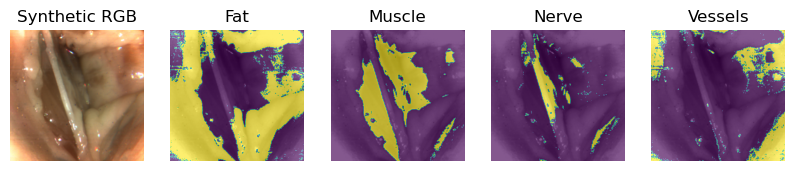

In [416]:
# create figure
# _data = data * std + mean
# _data = _data.T.reshape(-1, original_shape[1], original_shape[2]).numpy()
# r, g, b = _data[0], _data[1], _data[2]
# rgb_image = np.stack([r,g,b], axis=2)
fig, ax = plt.subplots(1, 5, figsize=(10, 5))
ax[0].imshow(rgb_image)
ax[0].set_title('Synthetic RGB')
ax[0].axis('off')
for i in range(4):
    mask = np.zeros_like(pred)
    mask[pred==i] = 1
    ax[i+1].imshow(ref_img, cmap='gray')
    ax[i+1].imshow(mask, alpha=0.66)
    ax[i+1].set_title(labels[i])
    ax[i+1].axis('off')

fig.savefig(os.path.join(config.RESULTS_DIR, 'Chapter6/LaparoscopyHSIBandSelection/other/SubjectB/pred.png'), dpi=300, bbox_inches='tight')
plt.show()

In [385]:
from sklearn import svm
from sklearn.model_selection import RandomizedSearchCV

def find_best_parameters(X: np.ndarray, y: np.ndarray, param_grid: dict, save_dir: str, 
                            cv:int = 5, n_iter:int=100, n_jobs:int=-1, random_state:int=42):
    '''
        Find the best parameters for the SVM classifier.

        Parameters
        ----------
        X_df : pd.DataFrame
            Dataframe with the features.

        y_df : pd.DataFrame
            Dataframe with the labels.

        param_grid : dict
            Dictionary with the parameters to be tested.

        cv : int
            Number of folds for the cross-validation.

        n_iter : int
            Number of iterations for the RandomizedSearchCV.

        n_jobs : int
            Number of jobs to run in parallel.

        random_state : int
            Random state.

        undersample_method : str
            Undersampling method.
    '''
    grid = RandomizedSearchCV(svm.SVC(), param_grid, refit=True, verbose=2, cv=cv, n_jobs=n_jobs, n_iter=n_iter, random_state=random_state)
    grid.fit(X, y)

    return pd.DataFrame(grid.best_params_, index=[0])

In [386]:
X, y = dataset[:]
# y = dataset.y.numpy()

param_grid = {'C': np.logspace(0, 2, 24), 'gamma': np.logspace(-3, 0, 24), 'kernel': ['rbf'],
              'decision_function_shape':['ovo'], 'probability': [True], 'random_state': [42]}

best_params_svc = find_best_parameters(X, y, param_grid, '.', cv=5, n_iter=25, n_jobs=-1, random_state=42)

Fitting 5 folds for each of 25 candidates, totalling 125 fits
[CV] END C=16.496480740980207, decision_function_shape=ovo, gamma=0.02015337685941733, kernel=rbf, probability=True, random_state=42; total time=   5.2s
[CV] END C=6.061898993497572, decision_function_shape=ovo, gamma=0.22275429519995563, kernel=rbf, probability=True, random_state=42; total time=   5.5s
[CV] END C=16.496480740980207, decision_function_shape=ovo, gamma=0.02015337685941733, kernel=rbf, probability=True, random_state=42; total time=   5.5s
[CV] END C=6.061898993497572, decision_function_shape=ovo, gamma=0.22275429519995563, kernel=rbf, probability=True, random_state=42; total time=   6.4s
[CV] END C=6.061898993497572, decision_function_shape=ovo, gamma=0.22275429519995563, kernel=rbf, probability=True, random_state=42; total time=   6.6s
[CV] END C=16.496480740980207, decision_function_shape=ovo, gamma=0.02015337685941733, kernel=rbf, probability=True, random_state=42; total time=   6.8s
[CV] END C=6.0618989934

In [387]:
best_params_svc

,random_state,probability,kernel,gamma,decision_function_shape,C
0,42,True,rbf,0.740568,ovo,2.227543


In [388]:
model = svm.SVC(**best_params_svc.iloc[0]).fit(X, y)

In [389]:
result = model.predict(data)

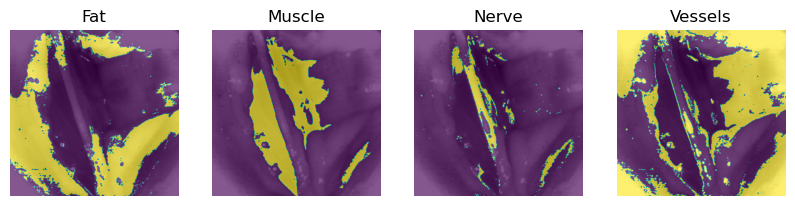

In [390]:
pred = result.reshape(original_shape[1], original_shape[2])

# create figure
fig, ax = plt.subplots(1, 4, figsize=(10, 5))
for i in range(4):
    mask = np.zeros_like(pred)
    mask[pred==i] = 1
    ax[i].imshow(ref_img, cmap='gray')
    ax[i].imshow(mask, alpha=0.66)
    ax[i].set_title(labels[i])
    ax[i].axis('off')
